In [209]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Suppress warnings for clarity
import warnings
warnings.filterwarnings("ignore")

In [210]:
# Part 1: Data Exploration and Preparation
# Load the Titanic dataset from Seaborn
def load_data():
    try:
        df = sns.load_dataset('titanic')
        print("Dataset loaded successfully.")
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

df = load_data()

df

Dataset loaded successfully.


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [211]:
## b. Identify null values and percentages
null_counts = df.isnull().sum()
null_percentage = (null_counts / len(df)) * 100
null_df = pd.DataFrame({'Null Count': null_counts, 'Null Percentage': null_percentage})
print(null_df)

             Null Count  Null Percentage
survived              0         0.000000
pclass                0         0.000000
sex                   0         0.000000
age                 177        19.865320
sibsp                 0         0.000000
parch                 0         0.000000
fare                  0         0.000000
embarked              2         0.224467
class                 0         0.000000
who                   0         0.000000
adult_male            0         0.000000
deck                688        77.216611
embark_town           2         0.224467
alive                 0         0.000000
alone                 0         0.000000


In [212]:
## c. Remove the feature with mostly null values
df = df.drop(columns=[null_df[null_df['Null Percentage'] > 75].index[0]])

In [213]:
## d. Identify redundant features
redundant_pairs = [('pclass', 'class'), ('sex', 'who'), ('embarked', 'embark_town')]
for col1, col2 in redundant_pairs:
    print(f"Checking redundancy between {col1} and {col2}:")
    print(df[[col1, col2]].drop_duplicates())

Checking redundancy between pclass and class:
   pclass   class
0       3   Third
1       1   First
9       2  Second
Checking redundancy between sex and who:
      sex    who
0    male    man
1  female  woman
7    male  child
9  female  child
Checking redundancy between embarked and embark_town:
   embarked  embark_town
0         S  Southampton
1         C    Cherbourg
5         Q   Queenstown
61      NaN          NaN


In [214]:
## e. Drop the redundant features
df = df.drop(columns=['class', 'who', 'embarked'])

##f. Document logic for 'adult_male':
#adult_male is engineered from features age and sex, such that if age is greater than or equal to 18, 
#and sex is 'male', then adult_male is True, else adult_male is False."

In [215]:
## g. Drop `adult_male` feature
df = df.drop(columns=['adult_male'])

Number of men and women who died:
survived    0    1  percentage_died
sex                                
female     81  233        25.796178
male      468  109        81.109185
Survival percentages by class:
pclass
1    62.962963
2    47.282609
3    24.236253
Name: survived, dtype: float64
Fare value distribution:
count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64


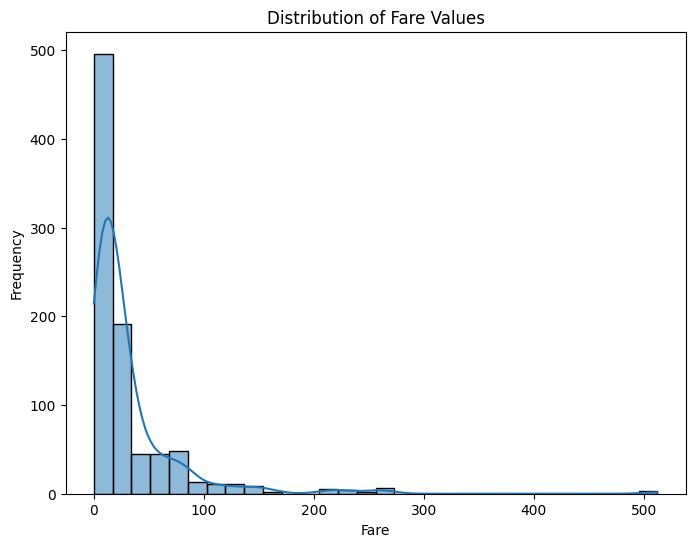

Age distribution:
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64


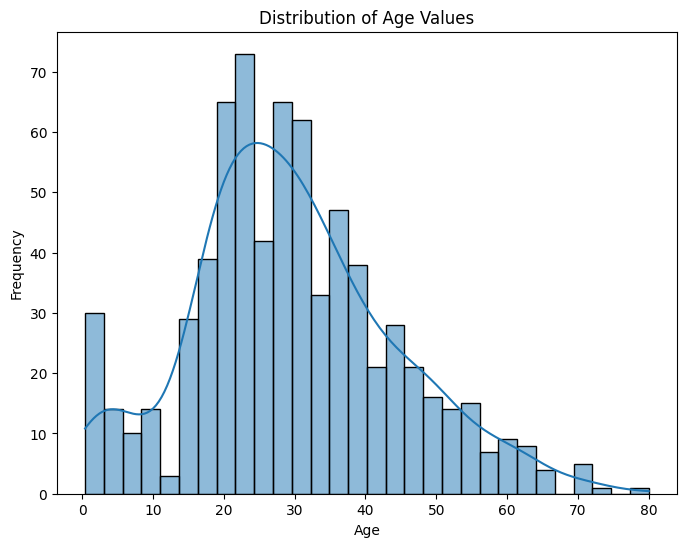

Median age per class:
pclass
1    37.0
2    29.0
3    24.0
Name: age, dtype: float64


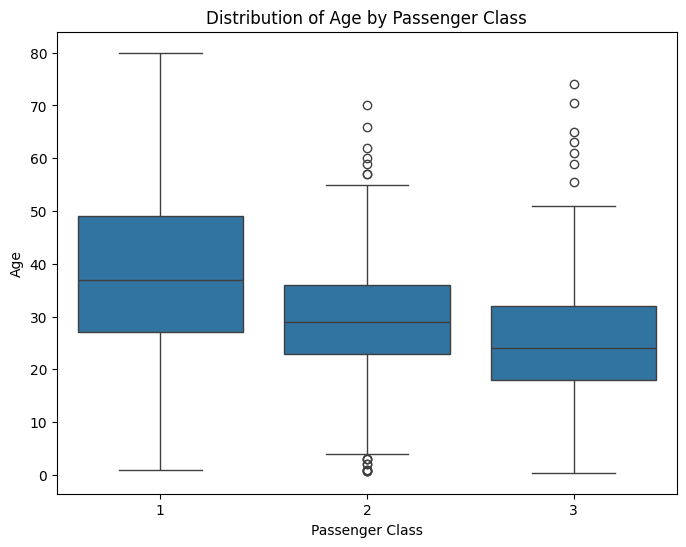

In [216]:
## h. Explore the data
### i. Did more women or men die on the Titanic?
death_counts = df.groupby('sex')['survived'].value_counts().unstack()
death_counts['percentage_died'] = (death_counts[0] / death_counts.sum(axis=1)) * 100
print("Number of men and women who died:")
print(death_counts)

### ii. What percentages of passengers survived by passenger class?
class_survival = df.groupby('pclass')['survived'].mean() * 100
print("Survival percentages by class:")
print(class_survival)

### iii. Describe the distribution of fare values
fare_description = df['fare'].describe()
print("Fare value distribution:")
print(fare_description)
plt.figure(figsize=(8, 6))
sns.histplot(df['fare'], bins=30, kde=True)
plt.title("Distribution of Fare Values")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.show()

### iv. Describe the distribution of non-null age values
age_description = df['age'].dropna().describe()
print("Age distribution:")
print(age_description)
plt.figure(figsize=(8, 6))
sns.histplot(df['age'].dropna(), bins=30, kde=True)
plt.title("Distribution of Age Values")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

### v. Median age for each passenger class
median_age_by_class = df.groupby('pclass')['age'].median()
print("Median age per class:")
print(median_age_by_class)

### vi. Box plot of age by passenger class
plt.figure(figsize=(8, 6))
sns.boxplot(x='pclass', y='age', data=df)
plt.title("Distribution of Age by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Age")
plt.show()


In [217]:
## i. Impute null age values using median age per class
df['age'] = df['age'].fillna(df.groupby('pclass')['age'].transform('median'))

In [218]:
## j. Drop remaining null values
df = df.dropna()
print(f"Remaining rows after dropping nulls: {len(df)}")

Remaining rows after dropping nulls: 889


In [219]:
## k. Identify categorical features
categorical_features = df.select_dtypes(include=['category', 'object']).columns
print("Categorical features:", categorical_features)

Categorical features: Index(['sex', 'embark_town', 'alive'], dtype='object')


In [220]:
## l. Identify additional categorical features
possible_categoricals = ['pclass', 'sibsp', 'parch', 'sex', 'embark_town', 'alive', 'alone']
print("Possible categorical features:", possible_categoricals)

Possible categorical features: ['pclass', 'sibsp', 'parch', 'sex', 'embark_town', 'alive', 'alone']


In [221]:
## m. Convert categorical features to numeric dummies
df = pd.get_dummies(df, columns=possible_categoricals, drop_first=True, dtype=int)
print(f"Final DataFrame shape: {df.shape}")

Final DataFrame shape: (889, 22)


In [222]:
## n. Create training and testing sets
X = df.drop(columns=['survived'])
y = df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Ensure all features are numeric
print("Feature Data Types in X_train:")
print(X_train.dtypes)
assert X_train.select_dtypes(include=['object']).shape[1] == 0, "There are still non-numeric columns in X_train!"

Feature Data Types in X_train:
age                        float64
fare                       float64
pclass_2                     int64
pclass_3                     int64
sibsp_1                      int64
sibsp_2                      int64
sibsp_3                      int64
sibsp_4                      int64
sibsp_5                      int64
sibsp_8                      int64
parch_1                      int64
parch_2                      int64
parch_3                      int64
parch_4                      int64
parch_5                      int64
parch_6                      int64
sex_male                     int64
embark_town_Queenstown       int64
embark_town_Southampton      int64
alive_yes                    int64
alone_True                   int64
dtype: object


In [223]:
## o. Verify target rate consistency
print("Target rate in entire dataset:", y.mean())
print("Target rate in training set:", y_train.mean())
print("Target rate in testing set:", y_test.mean())

Target rate in entire dataset: 0.38245219347581555
Target rate in training set: 0.38255977496483823
Target rate in testing set: 0.38202247191011235


#Part 2: Initial Model Training

In [224]:
## a. Instantiate models
log_reg = LogisticRegression()
svc = SVC(probability=True)
dec_tree = DecisionTreeClassifier()

In [225]:
## b. Perform cross-validation predictions
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method='predict_proba')
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method='predict_proba')
dec_tree_pred = cross_val_predict(dec_tree, X_train, y_train, cv=5, method='predict_proba')

In [226]:
## c. Evaluate models
def evaluate_model(name, y_true, y_pred_proba):
    y_pred = (y_pred_proba[:, 1] >= 0.5).astype(int)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"\n{name} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(f"\n{name} ROC-AUC Score: {roc_auc_score(y_true, y_pred_proba[:, 1])}")

evaluate_model("Logistic Regression", y_train, log_reg_pred)
evaluate_model("Support Vector Classifier", y_train, svc_pred)
evaluate_model("Decision Tree", y_train, dec_tree_pred)



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       1.00      1.00      1.00       272

    accuracy                           1.00       711
   macro avg       1.00      1.00      1.00       711
weighted avg       1.00      1.00      1.00       711


Logistic Regression Confusion Matrix:
[[439   0]
 [  0 272]]

Logistic Regression ROC-AUC Score: 1.0

Support Vector Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.91      0.78       439
           1       0.70      0.33      0.45       272

    accuracy                           0.69       711
   macro avg       0.69      0.62      0.62       711
weighted avg       0.69      0.69      0.65       711


Support Vector Classifier Confusion Matrix:
[[401  38]
 [183  89]]

Support Vector Classifier ROC-AUC Score: 0.8158289226852473

Decision Tree Classi

##Part 3: Model Tuning

In [227]:
## a. Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [228]:
## b. Cross-validation with scaled data
svc_pred_scaled = cross_val_predict(svc, X_train_scaled, y_train, cv=5, method='predict_proba')
evaluate_model("Support Vector Classifier (Scaled)", y_train, svc_pred_scaled)


Support Vector Classifier (Scaled) Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       439
           1       0.99      0.97      0.98       272

    accuracy                           0.99       711
   macro avg       0.99      0.98      0.99       711
weighted avg       0.99      0.99      0.99       711


Support Vector Classifier (Scaled) Confusion Matrix:
[[436   3]
 [  7 265]]

Support Vector Classifier (Scaled) ROC-AUC Score: 0.9993635267318772


##c. Compare evaluation metrics
#"Comparison of SVC before and after scaling: Scaling improves convergence and ROC-AUC score."

In [229]:
## d. Perform Grid Search with SVC
param_grid = {'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'C': [1, 10, 50, 100, 200, 300]}
grid_search = GridSearchCV(SVC(probability=True), param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 10, 50, 100, 200, 300],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             scoring='roc_auc')

In [230]:
## e. Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)

Best Parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Best ROC-AUC Score: 1.0


In [231]:
## f. Evaluate best estimator on test data
best_svc = grid_search.best_estimator_
best_svc_pred = best_svc.predict_proba(X_test_scaled)
evaluate_model("Best SVC Model", y_test, best_svc_pred)


Best SVC Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00        68

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178


Best SVC Model Confusion Matrix:
[[110   0]
 [  0  68]]

Best SVC Model ROC-AUC Score: 1.0
